In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import interp, stats
import os

from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold, cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_fscore_support,accuracy_score, roc_curve, auc, precision_recall_curve, average_precision_score

In [115]:
def pred_metric(y_prob,y_resp):

    y_ordered = [x for _,x in sorted(zip(y_prob,y_resp))]
    y_prob_ordered = [x for x,_ in sorted(zip(y_prob,y_resp))]
    sens = []
    spec = []
    prec = []
    nprv = []
    for i in range(len(y_ordered)):
        tn = y_ordered[0:i].count(0)
        fn = y_ordered[0:i].count(1)
        tp = y_ordered[i:].count(1)
        fp = y_ordered[i:].count(0)
#         print(i, tn, fn, tp, tp)
        if((tp+fn)!=0):
            sens.append(tp/(tp+fn))
        else:
            sens.append(1)
            
        if((tn+fp)!=0):
            spec.append(tn/(tn+fp))
        else:
            spec.append(1)
        
        if((tp+fp)!=0):
            prec.append(tp/(tp+fp))
        else:
            prec.append(1)
        
        if((tn+fn)!=0):
            nprv.append(tn/(tn+fn))
        else:
            nprv.append(1)
    
    return np.array(prec), np.array(sens), np.array(spec), np.array(nprv)
#     return np.array(sens), np.array(spec), np.array(prec), np.array(nprv), y_ordered, y_prob_ordered

def pred_metric_ch(y_prob, y_resp):
    Prec1, Rec1, Spe1, NPV1 = [], [], [], []
    for i in np.sort(y_prob.unique()):
        cm = confusion_matrix(y_resp, y_prob >= i)
        TN, TP, FN, FP = cm[0,0], cm[1,1], cm[1,0], cm[0,1]
        if((TP + FN)!=0):
            Rec1 = Rec1 + [TP / (TP + FN)]
        else:
            Rec1 = Rec1+[1]
        
        if ((TP + FP)!=0):
            Prec1 = Prec1 + [TP / (TP + FP)]
        else:
            Prec1 = Prec1 + [1]
    
        if ((TN + FP)!=0):
            Spe1 = Spe1 + [TN / (TN + FP)]
        else:
            Spe1 = Spe1 + [1]
        
        if((TN+FN)!=0):
            NPV1 = NPV1 + [TN / (TN + FN)]
        else:
            NPV1 = NPV1 + [1]
    return np.array(Prec1), np.array(Rec1), np.array(Spe1), np.array(NPV1)

In [116]:
## LOAD RESULTS
files = ['median_standar_anova_lr', 'median_anova_rf', 'median_anova_ert', 'median_anova_gb', 'median_escaler_anova_svc', 'median_standar_anova_lr_noreg']
files_out = files.copy()
for i,file in enumerate(files):
    files_out[i] = 'out_' + file + '_10.csv'

In [117]:
files_out

['out_median_standar_anova_lr_10.csv',
 'out_median_anova_rf_10.csv',
 'out_median_anova_ert_10.csv',
 'out_median_anova_gb_10.csv',
 'out_median_escaler_anova_svc_10.csv',
 'out_median_standar_anova_lr_noreg_10.csv']

In [118]:
df_lr = pd.read_csv('./results/out_median_standar_anova_lr_10.csv').drop('Unnamed: 0', axis = 1).tail(52600)
df_rf = pd.read_csv('./results/out_median_anova_rf_10.csv').drop('Unnamed: 0', axis = 1).tail(52600)
df_ert = pd.read_csv('./results/out_median_anova_ef_10.csv').drop('Unnamed: 0', axis = 1).tail(52600)
df_svc = pd.read_csv('./results/out_median_escaler_anova_svc_10.csv').drop('Unnamed: 0', axis = 1).tail(52600)
df_gb = pd.read_csv('./results/out_median_anova_gb_10.csv').drop('Unnamed: 0', axis = 1).tail(52600)
df_lr_noreg = pd.read_csv('./results/out_median_standar_anova_lr_noreg_10.csv').drop('Unnamed: 0', axis = 1).tail(52600)

In [119]:
def rocs(df_lr):
    rocs_lr = []
    for seed in df_lr.seed.unique():
        for split in df_lr.split.unique():
            rocs_lr = rocs_lr + [roc_auc_score(df_lr.loc[((df_lr.seed == seed) & (df_lr.split == split) & (df_lr.train_test == 1)), 'GT'],
                                               df_lr.loc[(df_lr.seed == seed) & (df_lr.split == split)  & (df_lr.train_test == 1), 'proba'])]
    return rocs_lr

def avg_pr(df_lr):
    avg_pr_lr = []
    for seed in df_lr.seed.unique():
        for split in df_lr.split.unique():
            avg_pr_lr = avg_pr_lr + [average_precision_score(df_lr.loc[((df_lr.seed == seed) & (df_lr.split == split) & (df_lr.train_test == 1)), 'GT'],
                                               df_lr.loc[(df_lr.seed == seed) & (df_lr.split == split)  & (df_lr.train_test == 1), 'proba'])]
    return avg_pr_lr


def avg_pr_noest(df_lr):
    avg_pr_lr = []
    for seed in df_lr.seed.unique():
        for split in df_lr.split.unique():
            avg_pr_lr = avg_pr_lr + [average_precision_score(df_lr.loc[((df_lr.seed == seed) & (df_lr.split == split) & (df_lr.train_test == 1)), 'GT'],
                                               1 - df_lr.loc[(df_lr.seed == seed) & (df_lr.split == split)  & (df_lr.train_test == 1), 'proba'], pos_label = 0)]
    return avg_pr_lr

In [120]:
rocs_lr = rocs(df_lr)
rocs_rf = rocs(df_rf)
rocs_ert = rocs(df_ert)
rocs_svc = rocs(df_svc)
rocs_gb = rocs(df_gb)
rocs_lr_noreg = rocs(df_lr_noreg)

In [121]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def mean_confidence_interval_corrected(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m = np.mean(a)
    var = np.var(a)
    var_bess = var * n / (n - 1)
    S = np.sqrt(var_bess * (1/n + 1/9))
    h = S * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def t_test_corregido(rocs1, rocs2, confidence = 0.95):
    n = len(rocs1)
    dif = np.array(rocs1) - np.array(rocs2)
    media = dif.mean()
    var_bess = dif.var() * n / (n-1)
    
    std_error = np.sqrt(var_bess * ((1 / n) + 1/9))
    t_statistic = media/std_error
    
    pvalue = scipy.stats.t.sf(np.absolute(t_statistic), df= n-1)
    return media, pvalue

In [122]:
t_test_corregido(rocs_ert, rocs_lr)

(0.030555555555555544, 0.2023766132967137)

In [123]:
df_presto = pd.read_excel('./results/df_presto.xls')
df_presto1_acc = pd.read_excel('./results/df_presto1_acc.xls')
df_presto2_acc = pd.read_excel('./results/df_presto2_acc.xls')
df_TLR = pd.read_excel('./results/df_TLR.xls')

In [124]:
rocs_presto1 = []
rocs_presto2 = []
rocs_TLR = []
rocs_presto1_acc = []
rocs_presto2_acc = []
rocs_TLR_acc = []
for seed in df_lr.seed.unique():
        for split in df_lr.split.unique():
            idx = list((df_lr.loc[((df_lr.seed == seed) & (df_lr.split == split) & (df_lr.train_test == 1)), 'idx']))
            rocs_presto1 = rocs_presto1 + [roc_auc_score(df_presto.loc[idx, 'reestenosis'], df_presto.loc[idx, 'presto1'])]
            rocs_presto2 = rocs_presto2 + [roc_auc_score(df_presto.loc[idx, 'reestenosis'], df_presto.loc[idx, 'presto2'])]
            rocs_TLR = rocs_TLR + [roc_auc_score(df_TLR.loc[idx, 'reestenosis'], df_TLR.loc[idx, 'TLR_score'])]
            rocs_presto1_acc = rocs_presto1_acc + [roc_auc_score(df_presto1_acc.loc[idx, 'reestenosis'], df_presto1_acc.loc[idx, 'presto1'])]
            rocs_presto2_acc = rocs_presto2_acc + [roc_auc_score(df_presto2_acc.loc[idx, 'reestenosis'], df_presto2_acc.loc[idx, 'presto2'])]
            rocs_TLR_acc = rocs_TLR_acc + [roc_auc_score(df_TLR.loc[idx, 'reestenosis'], df_TLR.loc[idx, 'TLR_acc_score'])]

In [125]:
print('PRESTO 1: ', mean_confidence_interval_corrected(rocs_presto1))
print('PRESTO 2: ', mean_confidence_interval_corrected(rocs_presto2))
print('TLR: ', mean_confidence_interval_corrected(rocs_TLR))
print('PRESTO 1 acc: ', mean_confidence_interval_corrected(rocs_presto1_acc))
print('PRESTO 2 acc: ', mean_confidence_interval_corrected(rocs_presto2_acc))
print('TLR acc: ', mean_confidence_interval_corrected(rocs_TLR_acc))

presto1_conf = mean_confidence_interval_corrected(rocs_presto1)
presto2_conf = mean_confidence_interval_corrected(rocs_presto2)
TLR_conf = mean_confidence_interval_corrected(rocs_TLR)

presto1_acc_conf = mean_confidence_interval_corrected(rocs_presto1_acc)
presto2_acc_conf = mean_confidence_interval_corrected(rocs_presto2_acc)
TLR_acc_conf = mean_confidence_interval_corrected(rocs_TLR_acc)

PRESTO 1:  (0.5672395833333334, 0.42978712900171223, 0.7046920376649545)
PRESTO 2:  (0.5802083333333333, 0.4371469845278454, 0.7232696821388213)
TLR:  (0.6174131944444444, 0.49840496303296705, 0.7364214258559217)
PRESTO 1 acc:  (0.5696354166666667, 0.42548465436756233, 0.7137861789657711)
PRESTO 2 acc:  (0.5610069444444444, 0.4138755754414542, 0.7081383134474346)
TLR acc:  (0.6144444444444445, 0.49644129927028835, 0.7324475896186006)


In [126]:
print('LR: ', mean_confidence_interval(rocs_lr))
print('RF: ', mean_confidence_interval(rocs_rf))
print('ert: ', mean_confidence_interval(rocs_ert))
print('SVC: ', mean_confidence_interval(rocs_svc))
print('GB: ', mean_confidence_interval(rocs_gb))
print('LR_noreg: ', mean_confidence_interval(rocs_lr_noreg))

lr_conf = mean_confidence_interval(rocs_lr)
rf_conf = mean_confidence_interval(rocs_rf)
ert_conf = mean_confidence_interval(rocs_ert)
svc_conf = mean_confidence_interval(rocs_svc)
gb_conf = mean_confidence_interval(rocs_gb)
lr_noreg_conf = mean_confidence_interval(rocs_lr_noreg)

LR:  (0.7417534722222223, 0.7176171797358428, 0.7658897647086018)
RF:  (0.7518402777777777, 0.7259682375983111, 0.7777123179572444)
ert:  (0.7723090277777778, 0.7480912723541336, 0.7965267832014219)
SVC:  (0.5312152777777777, 0.49851098206738326, 0.5639195734881721)
GB:  (0.6783680555555555, 0.6473385050355935, 0.7093976060755174)
LR_noreg:  (0.6988194444444444, 0.6734754140167117, 0.7241634748721771)


In [127]:
print('LR: ', mean_confidence_interval_corrected(rocs_lr))
print('RF: ', mean_confidence_interval_corrected(rocs_rf))
print('ert: ', mean_confidence_interval_corrected(rocs_ert))
print('SVC: ', mean_confidence_interval_corrected(rocs_svc))
print('GB: ', mean_confidence_interval_corrected(rocs_gb))
print('LR_noreg: ', mean_confidence_interval_corrected(rocs_lr_noreg))

lr_conf = mean_confidence_interval_corrected(rocs_lr)
rf_conf = mean_confidence_interval_corrected(rocs_rf)
ert_conf = mean_confidence_interval_corrected(rocs_ert)
svc_conf = mean_confidence_interval_corrected(rocs_svc)
gb_conf = mean_confidence_interval_corrected(rocs_gb)
lr_noreg_conf = mean_confidence_interval_corrected(rocs_lr_noreg)

LR:  (0.7417534722222223, 0.6254420279909381, 0.8580649164535066)
RF:  (0.7518402777777777, 0.6271643624448107, 0.8765161931107448)
ert:  (0.7723090277777778, 0.6556050182057345, 0.8890130373498211)
SVC:  (0.5312152777777777, 0.37361510497619416, 0.6888154505793611)
GB:  (0.6783680555555555, 0.5288383862055075, 0.8278977249056034)
LR_noreg:  (0.6988194444444444, 0.5766879785884229, 0.820950910300466)


In [128]:
# t-test corregido, devuelve media de la diferencia entre las dos muestras y p-valor
t_test_corregido(rocs_ert, rocs_svc)

(0.24109375, 0.0028584540146056993)

In [129]:
t_test_corregido(rocs_ert, rocs_TLR)

(0.15489583333333334, 0.022011844785024097)

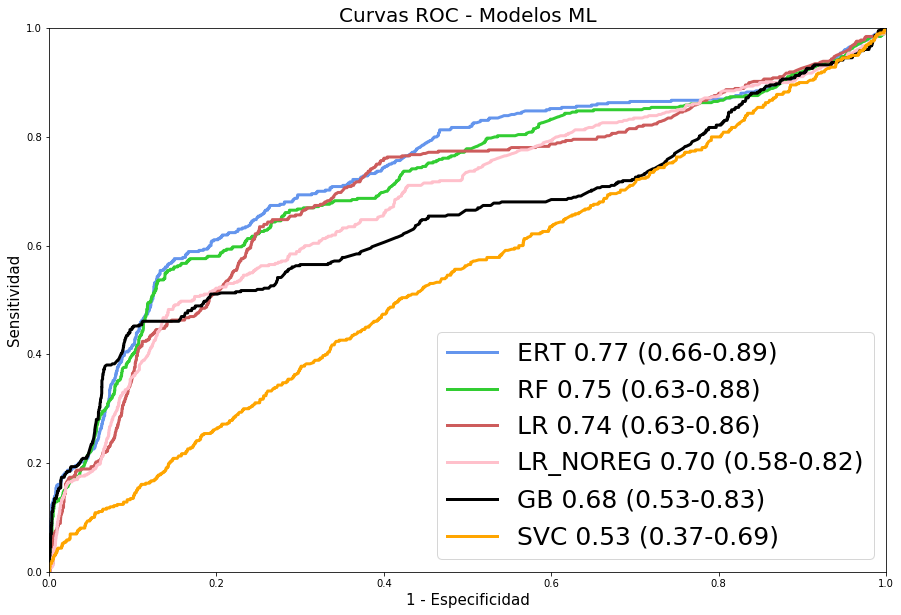

In [130]:
## CURVAS
#Curvas roc. Comparación de modelos

plt.figure(figsize=(15,10))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

model_names = ['ert', 'rf', 'lr', 'lr_noreg', 'gb', 'svc']
colors = ['cornflowerblue', 'limegreen', 'indianred', 'pink', 'black', 'orange']
model_zoo = [eval('df_' + name) for name in model_names]
roc_CI = [eval(name + '_conf') for name in model_names]

for i, model in enumerate(model_zoo):
    df_model = model.loc[((model.train_test == 1)), :]
    fpr1, tpr1, thresholds1 = roc_curve(df_model['GT'],df_model['proba'])
    plt.plot(fpr1, tpr1, lw=3, alpha=1, color = colors[i],
             label =  model_names[i].upper() + ' %0.2f (%0.2f-%0.2f)' % (roc_CI[i][0], roc_CI[i][1], roc_CI[i][2]))

plt.xlabel('1 - Especificidad', fontsize = 15)
plt.ylabel('Sensitividad', fontsize = 15)
plt.legend(loc="lower right", fontsize = 25)
plt.title('Curvas ROC - Modelos ML', fontsize = 20)    
plt.savefig("./images/roc_modelos.png")


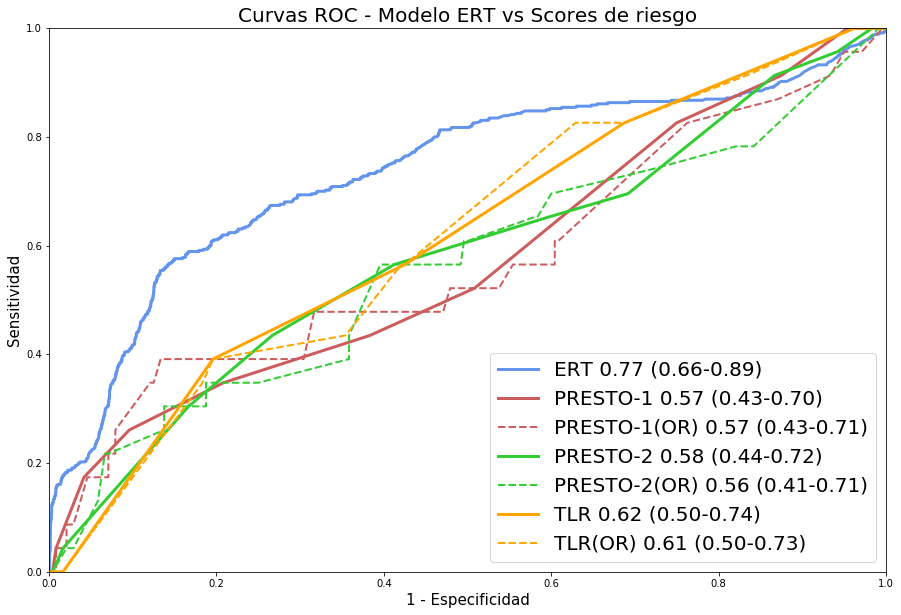

In [131]:
### Curvas roc. Mejor modelo y scores

plt.figure(figsize=(15,10))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

model_names = ['presto1', 'presto2', 'TLR', 'prest1_acc', 'presto2_acc', 'TLR_acc']
colors = ['indianred', 'limegreen', 'brown', 'black', 'purple', 'orange']
model_zoo = [df_lr, df_rf, df_ert, df_svc, df_gb, df_lr_noreg]
roc_CI = [lr_conf, rf_conf, ert_conf, svc_conf, gb_conf, lr_noreg_conf]

fpr1, tpr1, thresholds1 = roc_curve(df_ert.loc[df_ert.train_test == 1, 'GT'],df_ert.loc[df_ert.train_test == 1,'proba'])
plt.plot(fpr1, tpr1, lw=3, alpha=1, color = 'cornflowerblue',
         label = 'ERT %0.2f (%0.2f-%0.2f)' % (ert_conf[0], ert_conf[1], ert_conf[2]))

fpr2, tpr2, thresholds2 = roc_curve(df_presto['reestenosis'],df_presto['presto1'])
plt.plot(fpr2, tpr2, lw=3, alpha=1, color = 'indianred',
         label = 'PRESTO-1 %0.2f (%0.2f-%0.2f)' % (presto1_conf[0], presto1_conf[1], presto1_conf[2]))

fpr5, tpr5, thresholds5 = roc_curve(df_presto1_acc['reestenosis'],df_presto1_acc['presto1'])
plt.plot(fpr5, tpr5, lw=2, alpha=1, color = 'indianred', linestyle='dashed',
         label = 'PRESTO-1(OR) %0.2f (%0.2f-%0.2f)' % (presto1_acc_conf[0], presto1_acc_conf[1], presto1_acc_conf[2]))


fpr3, tpr3, thresholds3 = roc_curve(df_presto['reestenosis'],df_presto['presto2'])
plt.plot(fpr3, tpr3, lw=3, alpha=1, color = 'limegreen',
         label = 'PRESTO-2 %0.2f (%0.2f-%0.2f)' % (presto2_conf[0], presto2_conf[1], presto2_conf[2]))

fpr6, tpr6, thresholds6 = roc_curve(df_presto2_acc['reestenosis'],df_presto2_acc['presto2'])
plt.plot(fpr6, tpr6, lw=2, alpha=1, color = 'limegreen',linestyle='dashed',
         label = 'PRESTO-2(OR) %0.2f (%0.2f-%0.2f)' % (presto2_acc_conf[0], presto2_acc_conf[1], presto2_acc_conf[2]))


fpr4, tpr4, thresholds4 = roc_curve(df_TLR['reestenosis'], df_TLR['TLR_score'])
plt.plot(fpr4, tpr4, lw=3, alpha=1, color = 'orange',
         label = 'TLR %0.2f (%0.2f-%0.2f)' % (TLR_conf[0], TLR_conf[1], TLR_conf[2]))


fpr7, tpr7, thresholds7 = roc_curve(df_TLR['reestenosis'], df_TLR['TLR_acc_score'])
plt.plot(fpr7, tpr7, lw=2, alpha=1, color = 'orange',linestyle='dashed',
         label = 'TLR(OR) %0.2f (%0.2f-%0.2f)' % (TLR_acc_conf[0], TLR_acc_conf[1], TLR_acc_conf[2]))

          
plt.xlabel('1 - Especificidad', fontsize = 15)
plt.ylabel('Sensitividad', fontsize = 15)
plt.legend(loc="lower right", fontsize = 20)
plt.title('Curvas ROC - Modelo ERT vs Scores de riesgo', fontsize = 20) 
plt.savefig("./images/roc_bestmodel_risk_no_threshold.png")

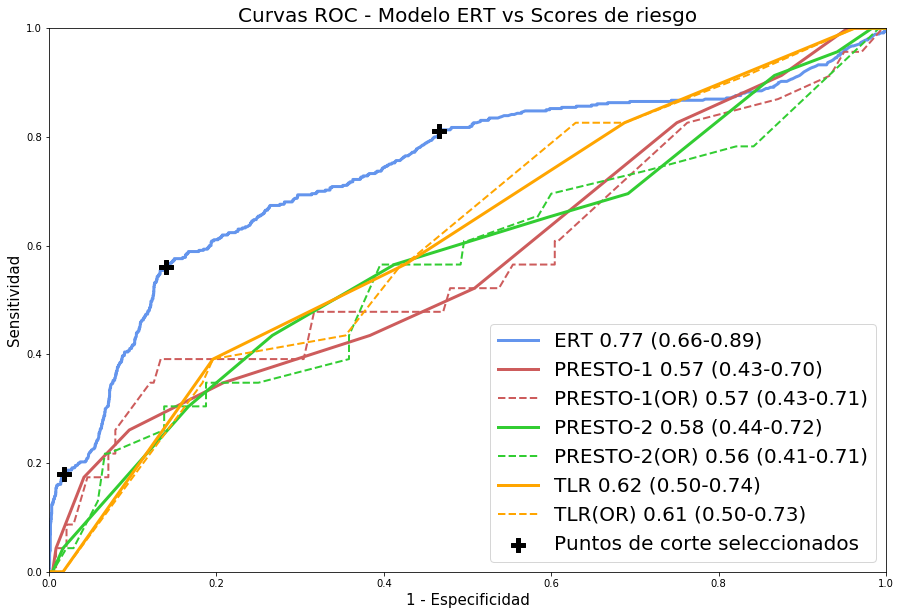

In [161]:
### Curvas roc. Mejor modelo y scores

plt.figure(figsize=(15,10))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

model_names = ['presto1', 'presto2', 'TLR', 'prest1_acc', 'presto2_acc', 'TLR_acc']
colors = ['indianred', 'limegreen', 'brown', 'black', 'purple', 'orange']
model_zoo = [df_lr, df_rf, df_ert, df_svc, df_gb, df_lr_noreg]
roc_CI = [lr_conf, rf_conf, ert_conf, svc_conf, gb_conf, lr_noreg_conf]

points_rec = [0.18, 0.56, 0.81]
points_fpr = [0.018, 0.14, 0.466]

plt.scatter(points_fpr, points_rec, lw = 1,  marker = "P", s=200, color = 'black',
            label = 'Puntos de corte seleccionados', zorder = 10)


fpr1, tpr1, thresholds1 = roc_curve(df_ert.loc[df_ert.train_test == 1, 'GT'],df_ert.loc[df_ert.train_test == 1,'proba'])
plt.plot(fpr1, tpr1, lw=3, alpha=1, color = 'cornflowerblue',
         label = 'ERT %0.2f (%0.2f-%0.2f)' % (ert_conf[0], ert_conf[1], ert_conf[2]))

fpr2, tpr2, thresholds2 = roc_curve(df_presto['reestenosis'],df_presto['presto1'])
plt.plot(fpr2, tpr2, lw=3, alpha=1, color = 'indianred',
         label = 'PRESTO-1 %0.2f (%0.2f-%0.2f)' % (presto1_conf[0], presto1_conf[1], presto1_conf[2]))

fpr5, tpr5, thresholds5 = roc_curve(df_presto1_acc['reestenosis'],df_presto1_acc['presto1'])
plt.plot(fpr5, tpr5, lw=2, alpha=1, color = 'indianred', linestyle='dashed',
         label = 'PRESTO-1(OR) %0.2f (%0.2f-%0.2f)' % (presto1_acc_conf[0], presto1_acc_conf[1], presto1_acc_conf[2]))


fpr3, tpr3, thresholds3 = roc_curve(df_presto['reestenosis'],df_presto['presto2'])
plt.plot(fpr3, tpr3, lw=3, alpha=1, color = 'limegreen',
         label = 'PRESTO-2 %0.2f (%0.2f-%0.2f)' % (presto2_conf[0], presto2_conf[1], presto2_conf[2]))

fpr6, tpr6, thresholds6 = roc_curve(df_presto2_acc['reestenosis'],df_presto2_acc['presto2'])
plt.plot(fpr6, tpr6, lw=2, alpha=1, color = 'limegreen',linestyle='dashed',
         label = 'PRESTO-2(OR) %0.2f (%0.2f-%0.2f)' % (presto2_acc_conf[0], presto2_acc_conf[1], presto2_acc_conf[2]))


fpr4, tpr4, thresholds4 = roc_curve(df_TLR['reestenosis'], df_TLR['TLR_score'])
plt.plot(fpr4, tpr4, lw=3, alpha=1, color = 'orange',
         label = 'TLR %0.2f (%0.2f-%0.2f)' % (TLR_conf[0], TLR_conf[1], TLR_conf[2]))


fpr7, tpr7, thresholds7 = roc_curve(df_TLR['reestenosis'], df_TLR['TLR_acc_score'])
plt.plot(fpr7, tpr7, lw=2, alpha=1, color = 'orange',linestyle='dashed',
         label = 'TLR(OR) %0.2f (%0.2f-%0.2f)' % (TLR_acc_conf[0], TLR_acc_conf[1], TLR_acc_conf[2]))
          
plt.xlabel('1 - Especificidad', fontsize = 15)
plt.ylabel('Sensitividad', fontsize = 15)
plt.legend(loc="lower right", fontsize = 20)
plt.title('Curvas ROC - Modelo ERT vs Scores de riesgo', fontsize = 20) 
plt.savefig("./images/roc_bestmodel_risk_threshold.png")

In [133]:
pr_lr = avg_pr(df_lr)
pr_rf = avg_pr(df_rf)
pr_ert = avg_pr(df_ert)
pr_svc = avg_pr(df_svc)
pr_gb = avg_pr(df_gb)
pr_lr_noreg = avg_pr(df_lr_noreg)

pr_lr_CI = mean_confidence_interval_corrected(pr_lr)
pr_ert_CI = mean_confidence_interval_corrected(pr_ert)
pr_rf_CI = mean_confidence_interval_corrected(pr_rf)
pr_svc_CI = mean_confidence_interval_corrected(pr_svc)
pr_gb_CI = mean_confidence_interval_corrected(pr_gb)
pr_lr_noreg_CI = mean_confidence_interval_corrected(pr_lr_noreg)

print(mean_confidence_interval_corrected(pr_lr))
print(mean_confidence_interval_corrected(pr_rf))
print(mean_confidence_interval_corrected(pr_ert))
print(mean_confidence_interval_corrected(pr_svc))
print(mean_confidence_interval_corrected(pr_gb))
print(mean_confidence_interval_corrected(pr_lr_noreg))

(0.389897750260787, 0.24340577208233893, 0.536389728439235)
(0.42619336089457577, 0.26591304670107185, 0.5864736750880797)
(0.4553348279832969, 0.28808388985395, 0.6225857661126437)
(0.2151564137809452, 0.10737602465187646, 0.3229368029100139)
(0.38427701545437104, 0.2245615726966478, 0.5439924582120943)
(0.3504742388229146, 0.20598432974805295, 0.4949641478977763)


In [134]:
pr_presto1 = []
pr_presto2 = []
pr_TLR = []
pr_presto1_acc = []
pr_presto2_acc = []
pr_TLR_acc = []
for seed in df_lr.seed.unique():
        for split in df_lr.split.unique():
            idx = list((df_lr.loc[((df_lr.seed == seed) & (df_lr.split == split) & (df_lr.train_test == 1)), 'idx']))
            pr_presto1 = pr_presto1 + [average_precision_score(df_presto.loc[idx, 'reestenosis'], df_presto.loc[idx, 'presto1'])]
            pr_presto2 = pr_presto2 + [average_precision_score(df_presto.loc[idx, 'reestenosis'], df_presto.loc[idx, 'presto2'])]
            pr_TLR = pr_TLR + [average_precision_score(df_TLR.loc[idx, 'reestenosis'], df_TLR.loc[idx, 'TLR_score'])]
            pr_presto1_acc = pr_presto1_acc + [average_precision_score(df_presto1_acc.loc[idx, 'reestenosis'], df_presto1_acc.loc[idx, 'presto1'])]
            pr_presto2_acc = pr_presto2_acc + [average_precision_score(df_presto2_acc.loc[idx, 'reestenosis'], df_presto2_acc.loc[idx, 'presto2'])]
            pr_TLR_acc = pr_TLR_acc + [average_precision_score(df_TLR.loc[idx, 'reestenosis'], df_TLR.loc[idx, 'TLR_acc_score'])]
pr_presto1_CI = mean_confidence_interval_corrected(pr_presto1)
pr_presto2_CI = mean_confidence_interval_corrected(pr_presto1)
pr_TLR_CI = mean_confidence_interval_corrected(pr_TLR)
            
print(mean_confidence_interval_corrected(pr_presto1))
print(mean_confidence_interval_corrected(pr_presto2))
print(mean_confidence_interval_corrected(pr_TLR))
print(mean_confidence_interval_corrected(pr_presto1_acc))
print(mean_confidence_interval_corrected(pr_presto2_acc))
print(mean_confidence_interval_corrected(pr_TLR_acc))

(0.2527153629813636, 0.12450434162258675, 0.3809263843401405)
(0.22884570083255387, 0.11859316736841989, 0.33909823429668784)
(0.16623038948669921, 0.11297454724074832, 0.2194862317326501)
(0.2900760068027138, 0.1519053762835594, 0.4282466373218682)
(0.24859465250549767, 0.12048697210095174, 0.3767023329100436)
(0.17472549281130095, 0.11884775156095177, 0.23060323406165012)


In [135]:
pr_lr_CI = mean_confidence_interval_corrected(pr_lr)
pr_ert_CI = mean_confidence_interval_corrected(pr_ert)

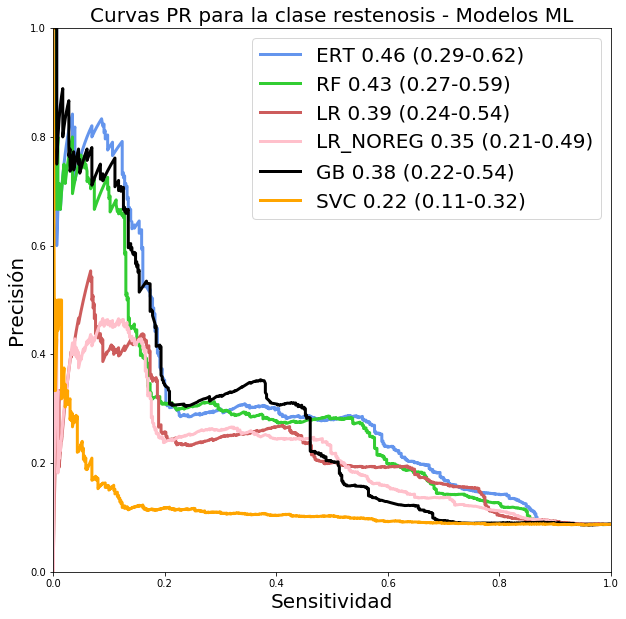

In [136]:
plt.figure(figsize = (10,10))
# plt.grid()
plt.title('Curvas PR para la clase restenosis - Modelos ML', fontsize = 20)

model_names = ['ert', 'rf', 'lr', 'lr_noreg', 'gb', 'svc']
colors = ['cornflowerblue', 'limegreen', 'indianred', 'pink', 'black', 'orange']
model_zoo = [eval('df_' + name) for name in model_names]
roc_CI = [eval('pr_' + name + '_CI') for name in model_names]

for i, model in enumerate(model_zoo):
    df_model = model.loc[((model.train_test == 1)), :]
    precision1, recall1, thresholds1 = precision_recall_curve(df_model.loc[:, 'GT'],df_model['proba'])
    plt.plot(recall1, precision1, lw=3, alpha=1, color = colors[i],
             label =  model_names[i].upper() + ' %0.2f (%0.2f-%0.2f)' % (roc_CI[i][0], roc_CI[i][1], roc_CI[i][2]))

plt.ylabel('Precisión', fontsize = 20)
plt.xlabel('Sensitividad', fontsize = 20)
plt.legend(loc="best", fontsize = 20)
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.savefig('./images/pr_est_modelos.png')

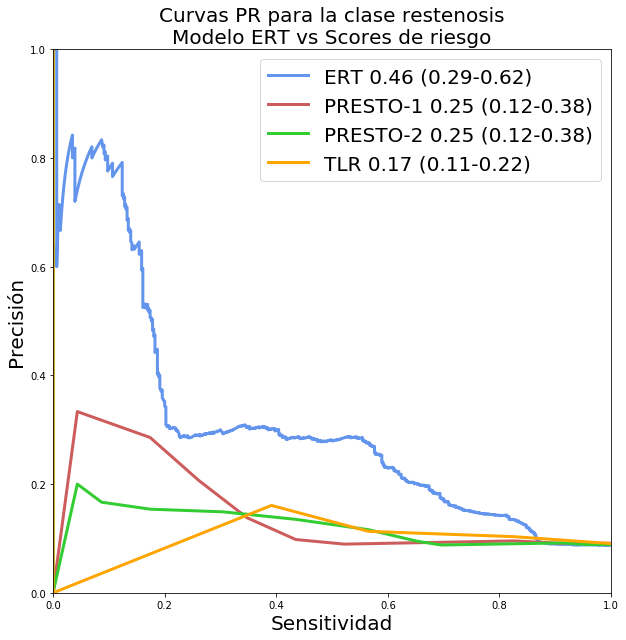

In [147]:
plt.figure(figsize = (10,10))
plt.title('Curvas PR para la clase restenosis\nModelo ERT vs Scores de riesgo', fontsize = 20)
precision11, recall11, thresholds11 = precision_recall_curve(df_ert.loc[df_ert.train_test ==1 , 'GT'], df_ert.loc[df_ert.train_test ==1 , 'proba'], pos_label=1)
precision12, recall12, thresholds12 = precision_recall_curve(df_lr.loc[df_lr.train_test ==1 , 'GT'], df_lr.loc[df_lr.train_test ==1 , 'proba'], pos_label=1)

precision3, recall3, thresholds3 = precision_recall_curve(df_presto['reestenosis'], df_presto['presto1'], pos_label=1)
precision4, recall4, thresholds4 = precision_recall_curve(df_presto['reestenosis'], df_presto['presto2'], pos_label=1)
precision5, recall5, thresholds5 = precision_recall_curve(df_TLR['reestenosis'], df_TLR['TLR_score'], pos_label=1)

plt.plot(recall11, precision11, lw = 3, color = 'cornflowerblue',  label = 'ERT %0.2f (%0.2f-%0.2f)' % (pr_ert_CI[0], pr_ert_CI[1], pr_ert_CI[2]))
plt.plot(recall3, precision3, lw = 3, color = 'indianred', label = 'PRESTO-1 %0.2f (%0.2f-%0.2f)' % (pr_presto1_CI[0], pr_presto1_CI[1], pr_presto1_CI[2]))
plt.plot(recall4, precision4, lw = 3, color = 'limegreen', label = 'PRESTO-2 %0.2f (%0.2f-%0.2f)' % (pr_presto2_CI[0], pr_presto2_CI[1], pr_presto2_CI[2]))
plt.plot(recall5, precision5, lw = 3, color = 'orange', label = 'TLR %0.2f (%0.2f-%0.2f)' % (pr_TLR_CI[0], pr_TLR_CI[1], pr_TLR_CI[2]))

plt.ylabel('Precisión', fontsize = 20)
plt.xlabel('Sensitividad', fontsize = 20)
plt.legend(loc="best", fontsize = 20)
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.savefig('./images/pr_curves_est_no_threshold.png')

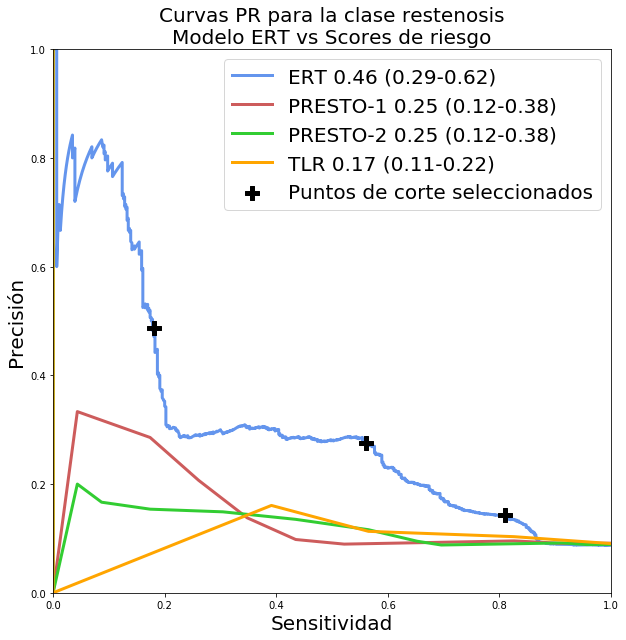

In [146]:
plt.figure(figsize = (10,10))
plt.title('Curvas PR para la clase restenosis\nModelo ERT vs Scores de riesgo', fontsize = 20)
precision11, recall11, thresholds11 = precision_recall_curve(df_ert.loc[df_ert.train_test ==1 , 'GT'], df_ert.loc[df_ert.train_test ==1 , 'proba'], pos_label=1)
precision12, recall12, thresholds12 = precision_recall_curve(df_lr.loc[df_lr.train_test ==1 , 'GT'], df_lr.loc[df_lr.train_test ==1 , 'proba'], pos_label=1)

precision3, recall3, thresholds3 = precision_recall_curve(df_presto['reestenosis'], df_presto['presto1'], pos_label=1)
precision4, recall4, thresholds4 = precision_recall_curve(df_presto['reestenosis'], df_presto['presto2'], pos_label=1)
precision5, recall5, thresholds5 = precision_recall_curve(df_TLR['reestenosis'], df_TLR['TLR_score'], pos_label=1)


points_rec = [0.18, 0.56, 0.81]
points_prec = [0.488, 0.276, 0.143]
plt.scatter(points_rec, points_prec, marker = "P", s= 200, color = 'black',
            label = 'Puntos de corte seleccionados',  zorder = 10)

plt.plot(recall11, precision11, lw = 3, color = 'cornflowerblue',  label = 'ERT %0.2f (%0.2f-%0.2f)' % (pr_ert_CI[0], pr_ert_CI[1], pr_ert_CI[2]))
plt.plot(recall3, precision3, lw = 3, color = 'indianred', label = 'PRESTO-1 %0.2f (%0.2f-%0.2f)' % (pr_presto1_CI[0], pr_presto1_CI[1], pr_presto1_CI[2]))
plt.plot(recall4, precision4, lw = 3, color = 'limegreen', label = 'PRESTO-2 %0.2f (%0.2f-%0.2f)' % (pr_presto2_CI[0], pr_presto2_CI[1], pr_presto2_CI[2]))
plt.plot(recall5, precision5, lw = 3, color = 'orange', label = 'TLR %0.2f (%0.2f-%0.2f)' % (pr_TLR_CI[0], pr_TLR_CI[1], pr_TLR_CI[2]))

plt.ylabel('Precisión', fontsize = 20)
plt.xlabel('Sensitividad', fontsize = 20)
plt.legend(loc="best", fontsize = 20)
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.savefig('./images/pr_curves_est_threshold.png')

In [139]:
pr_norest_ert = avg_pr_noest(df_ert)
pr_norest_lr = avg_pr_noest(df_lr)
pr_norest_rf = avg_pr_noest(df_rf)
pr_norest_gb = avg_pr_noest(df_gb)
pr_norest_svc = avg_pr_noest(df_svc)
pr_norest_lr_noreg = avg_pr_noest(df_lr_noreg)

pr_norest_ert_CI = mean_confidence_interval_corrected(pr_norest_ert)
pr_norest_lr_CI = mean_confidence_interval_corrected(pr_norest_lr)
pr_norest_rf_CI = mean_confidence_interval_corrected(pr_norest_rf)
pr_norest_gb_CI = mean_confidence_interval_corrected(pr_norest_gb)
pr_norest_svc_CI = mean_confidence_interval_corrected(pr_norest_svc)
pr_norest_lr_noreg_CI = mean_confidence_interval_corrected(pr_norest_lr_noreg)

In [140]:
pr_norest_presto1 = []
pr_norest_presto2 = []
pr_norest_TLR = []
pr_norest_presto1_acc = []
pr_norest_presto2_acc = []
pr_norest_TLR_acc = []
for seed in df_lr.seed.unique():
        for split in df_lr.split.unique():
            idx = list((df_lr.loc[((df_lr.seed == seed) & (df_lr.split == split) & (df_lr.train_test == 1)), 'idx']))
            pr_norest_presto1 = pr_norest_presto1 + [average_precision_score(df_presto.loc[idx, 'reestenosis'], 1 - df_presto.loc[idx, 'presto1'], pos_label = 0)]
            pr_norest_presto2 = pr_norest_presto2 + [average_precision_score(df_presto.loc[idx, 'reestenosis'], 1 - df_presto.loc[idx, 'presto2'], pos_label = 0)]
            pr_norest_TLR = pr_norest_TLR + [average_precision_score(df_TLR.loc[idx, 'reestenosis'], 1 - df_TLR.loc[idx, 'TLR_score'], pos_label = 0)]
            pr_norest_presto1_acc = pr_norest_presto1_acc + [average_precision_score(df_presto1_acc.loc[idx, 'reestenosis'], 1 - df_presto1_acc.loc[idx, 'presto1'], pos_label = 0)]
            pr_norest_presto2_acc = pr_norest_presto2_acc + [average_precision_score(df_presto2_acc.loc[idx, 'reestenosis'], 1 - df_presto2_acc.loc[idx, 'presto2'], pos_label = 0)]
            pr_norest_TLR_acc = pr_norest_TLR_acc + [average_precision_score(df_TLR.loc[idx, 'reestenosis'], 1 - df_TLR.loc[idx, 'TLR_acc_score'], pos_label = 0)]
pr_norest_presto1_CI = mean_confidence_interval_corrected(pr_norest_presto1)
pr_norest_presto2_CI = mean_confidence_interval_corrected(pr_norest_presto1)
pr_norest_TLR_CI = mean_confidence_interval_corrected(pr_norest_TLR)
            
print(mean_confidence_interval_corrected(pr_norest_presto1))
print(mean_confidence_interval_corrected(pr_norest_presto2))
print(mean_confidence_interval_corrected(pr_norest_TLR))
print(mean_confidence_interval_corrected(pr_norest_presto1_acc))
print(mean_confidence_interval_corrected(pr_norest_presto2_acc))
print(mean_confidence_interval_corrected(pr_norest_TLR_acc))

(0.9307689379704229, 0.9052878214485528, 0.9562500544922931)
(0.9319939722144762, 0.90429344262248, 0.9596945018064724)
(0.9376750620638936, 0.915092585232936, 0.9602575388948512)
(0.9290269685957093, 0.8987782582316656, 0.9592756789597531)
(0.9252894146787249, 0.8930972078565029, 0.957481621500947)
(0.9400486243190431, 0.9168180842676855, 0.9632791643704007)


In [141]:
t_test_corregido(pr_norest_ert, pr_norest_TLR)

(0.02620644983398148, 0.04169384092464181)

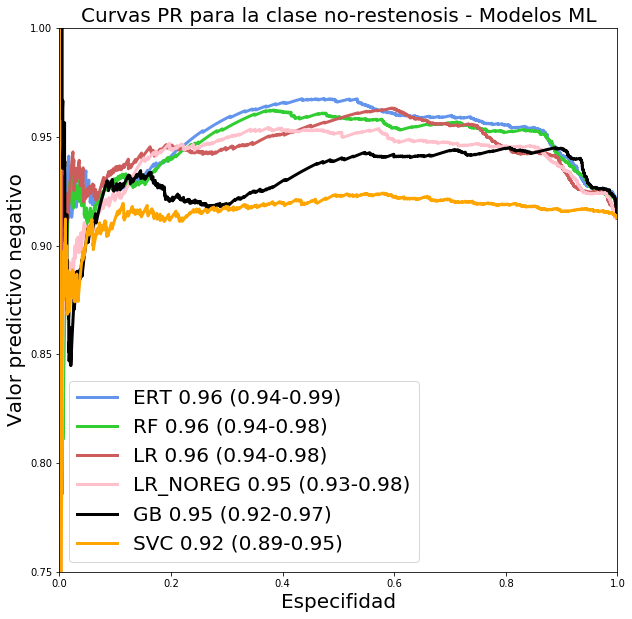

In [148]:
plt.figure(figsize = (10,10))
# plt.grid()
plt.title("Curvas PR para la clase no-restenosis - Modelos ML", fontsize = 20)

model_names = ['ert', 'rf', 'lr', 'lr_noreg', 'gb', 'svc']
colors = ['cornflowerblue', 'limegreen', 'indianred', 'pink', 'black', 'orange']
model_zoo = [eval('df_' + name) for name in model_names]
roc_CI = [eval('pr_norest_' + name + '_CI') for name in model_names]

for i, model in enumerate(model_zoo):
    df_model = model.loc[((model.train_test == 1)), :]
    Prec1, Rec1, Spe1, NPV1 = pred_metric(df_model['proba'], df_model['GT'])
    plt.plot(Spe1, NPV1, lw=3, alpha=1, color = colors[i],
             label =  model_names[i].upper() + ' %0.2f (%0.2f-%0.2f)' % (roc_CI[i][0], roc_CI[i][1], roc_CI[i][2]))

plt.ylabel('Valor predictivo negativo', fontsize = 20)
plt.xlabel('Especifidad', fontsize = 20)
plt.legend(loc="best", fontsize = 20)
plt.ylim([0.75, 1.0])
plt.xlim([0.0, 1.0])
plt.savefig('./images/npv_curves_models.png')

In [149]:
## Para curvas PR de scores
Prec1, Rec1, Spe1, NPV1 = pred_metric_ch(df_presto['presto1'], df_presto['reestenosis'])
Prec2, Rec2, Spe2, NPV2 = pred_metric_ch(df_presto['presto2'], df_presto['reestenosis'])
Prec3, Rec3, Spe3, NPV3 = pred_metric_ch(df_TLR['TLR_score'], df_TLR['reestenosis'])


## Para curvas PR de modelos
Prec4, Rec4, Spe4, NPV4 = pred_metric(df_ert.loc[df_ert.train_test == 1, 'proba'],
                                      df_ert.loc[df_ert.train_test == 1,'GT'])
# Prec5, Rec5, Spe5, NPV5 = pred_metric(df_results['lr'], df_results['y_real'])

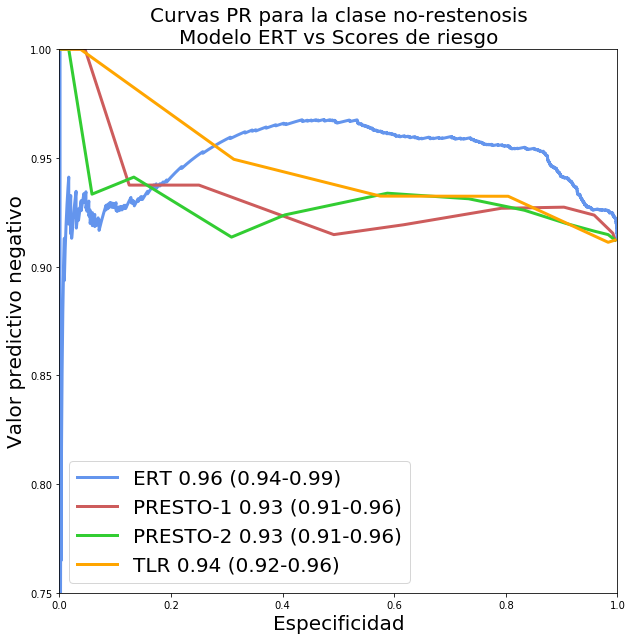

In [163]:
plt.figure(figsize = (10,10))
plt.title("Curvas PR para la clase no-restenosis\nModelo ERT vs Scores de riesgo", fontsize = 20)

plt.plot(Spe4, NPV4, lw = 3, color = 'cornflowerblue', label = 'ERT %0.2f (%0.2f-%0.2f)' % (pr_norest_ert_CI[0], pr_norest_ert_CI[1], pr_norest_ert_CI[2]))
plt.plot(Spe1, NPV1, lw = 3, color = 'indianred', label = 'PRESTO-1 %0.2f (%0.2f-%0.2f)' % (pr_norest_presto1_CI[0], pr_norest_presto1_CI[1], pr_norest_presto1_CI[2]))
plt.plot(Spe2, NPV2, lw = 3,color = 'limegreen', label = 'PRESTO-2 %0.2f (%0.2f-%0.2f)' % (pr_norest_presto2_CI[0], pr_norest_presto2_CI[1], pr_norest_presto2_CI[2]))
plt.plot(Spe3, NPV3, lw = 3,color = 'orange', label = 'TLR %0.2f (%0.2f-%0.2f)' % (pr_norest_TLR_CI[0], pr_norest_TLR_CI[1], pr_norest_TLR_CI[2]))

plt.ylabel('Valor predictivo negativo', fontsize = 20)
plt.xlabel('Especificidad', fontsize = 20)
plt.legend(loc="best", fontsize = 20)
plt.ylim([0.75, 1.0])
plt.xlim([0.0, 1.0])
plt.savefig('./images/npv_curves_no_threshold.png')

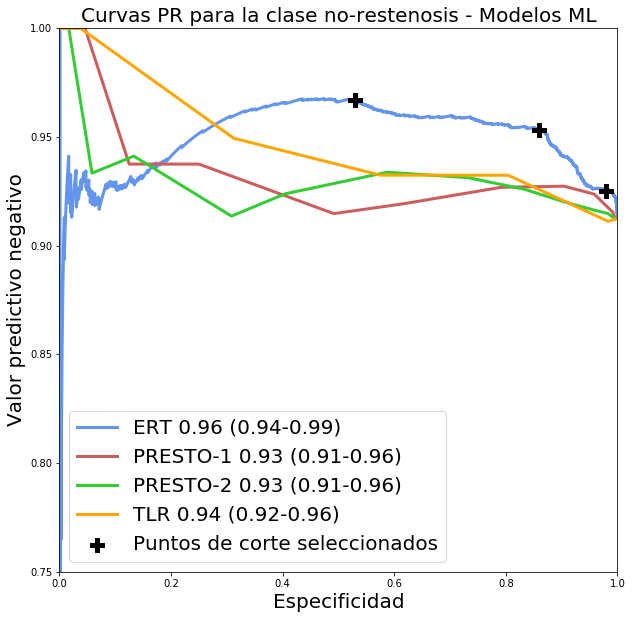

In [162]:
plt.figure(figsize = (10,10))
plt.title("Curvas PR para la clase no-restenosis - Modelos ML", fontsize = 20)

plt.plot(Spe4, NPV4, lw = 3, color = 'cornflowerblue', label = 'ERT %0.2f (%0.2f-%0.2f)' % (pr_norest_ert_CI[0], pr_norest_ert_CI[1], pr_norest_ert_CI[2]))
plt.plot(Spe1, NPV1, lw = 3, color = 'indianred', label = 'PRESTO-1 %0.2f (%0.2f-%0.2f)' % (pr_norest_presto1_CI[0], pr_norest_presto1_CI[1], pr_norest_presto1_CI[2]))
plt.plot(Spe2, NPV2, lw = 3,color = 'limegreen', label = 'PRESTO-2 %0.2f (%0.2f-%0.2f)' % (pr_norest_presto2_CI[0], pr_norest_presto2_CI[1], pr_norest_presto2_CI[2]))
plt.plot(Spe3, NPV3, lw = 3,color = 'orange', label = 'TLR %0.2f (%0.2f-%0.2f)' % (pr_norest_TLR_CI[0], pr_norest_TLR_CI[1], pr_norest_TLR_CI[2]))

points_spe = [0.53, 0.86, 0.98]
points_npv = [0.967, 0.953, 0.925]
plt.scatter(points_spe, points_npv, marker = "P", s= 200, color = 'black', label = 'Puntos de corte seleccionados',  zorder = 10)

plt.ylabel('Valor predictivo negativo', fontsize = 20)
plt.xlabel('Especificidad', fontsize = 20)
plt.legend(loc="best", fontsize = 20)
plt.ylim([0.75, 1.0])
plt.xlim([0.0, 1.0])
plt.savefig('./images/npv_curves_threshold.png')

In [152]:
## CUTOFFS
cm = confusion_matrix(df_ert.loc[df_ert.train_test == 1, 'GT'],
                      df_ert.loc[df_ert.train_test == 1, 'proba'] >= 0.68) * 100 / 5260
TN, TP, FN, FP = cm[0,0], cm[1,1], cm[1,0], cm[0,1]
Prec = TP / (TP + FP)
Rec = TP / (TP + FN)
Spe = TN / (TN + FN)
NPV = TN / (TN + FP)
print(cm)
print(Prec, Rec, Spe, NPV)

[[9.12167300e+01 3.80228137e-02]
 [8.66920152e+00 7.60456274e-02]]
0.6666666666666666 0.008695652173913044 0.9132089836315188 0.9995833333333333


In [153]:
## Cálculo de números con diferentes thresholds
from scipy import interpolate
f_tlr = interpolate.interp1d(Rec1, Prec1)
f_ert = interpolate.interp1d(Rec4, Prec4)

In [154]:
prev = 23 / (263)
REC = 0.81
PREC = float(f_ert(REC))
real_pos = 100*prev
TP = REC * real_pos
FN = real_pos - TP
pred_pos = TP / PREC
FP = TP / PREC - TP
TN = 100 - TP - FN - FP
NPV = TN / (TN + FN)
SPE = TN / (TN + FP)

In [155]:
SPE, PREC, NPV, TP, TN, FP, FN, 1-SPE

(0.5337081030647165,
 0.14271481624744597,
 0.9670088945852643,
 7.083650190114069,
 48.703401040126224,
 42.55135181158481,
 1.6615969581749042,
 0.4662918969352835)

## FEATURE IMPORTANCES

In [156]:
weights = pd.read_excel('./results/feature_importances2.xls')

In [157]:
list(weights.head(6)['feature'])

['diabetes',
 'angio.illvess2',
 'timi_post',
 'lab.plt.a',
 'thrombus_post',
 'lab.cho.a']

In [158]:
weights['weight_scaled'] = weights['weight'] / weights['weight'].max()

In [159]:
weights.head(11)

,feature,weight,std,weight_scaled
0,diabetes,0.114200,0.019100,1.000000
1,angio.illvess2,0.060154,0.018909,0.526743
2,timi_post,0.058077,0.011878,0.508553
3,lab.plt.a,0.034912,0.001844,0.305713
4,thrombus_post,0.023578,0.013999,0.206462
5,lab.cho.a,0.016383,0.009905,0.143458
6,perc_diam_post,0.000000,0.000000,0.000000
7,obs_length_pre,0.000000,0.000000,0.000000
8,perc_diam_pre,0.000000,0.000000,0.000000
9,perc_area_sten_pre,0.000000,0.000000,0.000000


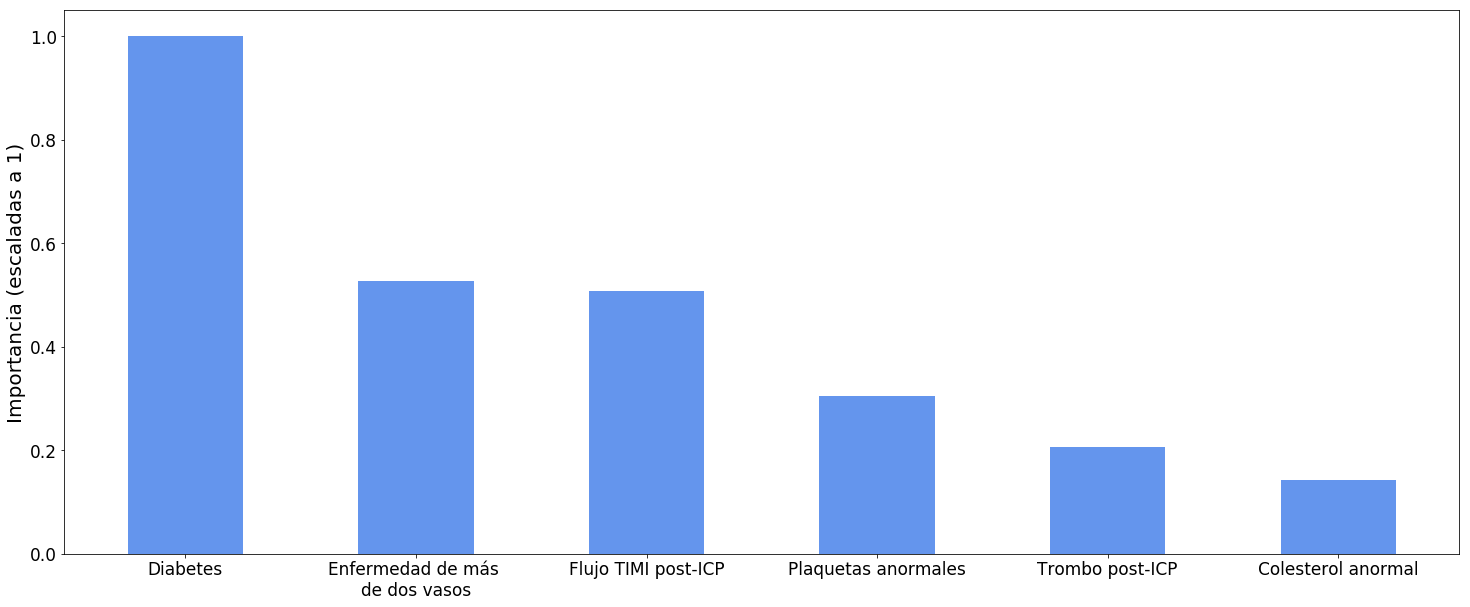

In [160]:
plt.figure(figsize=(25,10))
plt.xticks(rotation=0, fontsize = 17)
plt.yticks(rotation=0, fontsize = 17)

nombres = ['Diabetes',  u'\u2265' + ' 2 vessel\ndisease', 'Post-PCI\nTIMI flow', 'Abnormal\nplatelets', 
           'Post-PCI\nthrombus', 'Abnormal\ntotal\ncholesterol']

nombres = ['Diabetes', 'Enfermedad de más \nde dos vasos', 'Flujo TIMI post-ICP', 'Plaquetas anormales',
           'Trombo post-ICP', 'Colesterol anormal']


plt.bar(nombres, weights.loc[:5,'weight_scaled'], width = 0.5, color = 'cornflowerblue')
plt.xticks(rotation=0)
plt.ylabel('Importancia (escaladas a 1)', fontsize = 20)
plt.savefig('./images/importancias.png')